In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0704.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0758.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0946.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_1057.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0980.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0759.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary/Tr-pi_0593.jpg
/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation/pituitary

# **Introduction**

<span style="font-size:18px;">For my first project, I decided to build a classification model for MRI images of brain tumors, using a transfer learning approach with
VGG-16.</span>

<span style="font-size:18px;">So as a biologist, I will explain the data a bit 😊</span>

<span style="font-size:18px;">We have 4 classes: </span>

* <span style="font-size:18px;"> No tumor</span>

* <span style="font-size:18px;"> Pituitary tumor -  this tumor is located in the pituitary gland. The tumor is benign and is caused by abnormal growth of glandular cells pituitary.</span>

* <span style="font-size:18px;"> Meningioma tumor - most of these tumors are benign and form on membranes that cover the brain and spinal cord.</span>

* <span style="font-size:18px;"> Glioma tumor - this tumor is malignant and occurs in the brain or the spinal cord from the abnormal growth of Glioma cells.</span>

<span style="font-size:18px;">The MRI scans are in grayscale, and the difference between some tumors can be very small, so I think it's a challenge for the model to classify the scans, I hope that by fine-tuning he will success getting good results.<span>
    
<span style="font-size:18px;">I enjoyed exploring the data and to check how different hyper-parameters influence the model.</span>

<span style="font-size:18px;">I hope that you will enjoy from my project too 😊</span>

# **Import Libraries**

In [2]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

import cv2
import matplotlib.pyplot as plt
from collections import Counter

# **Data Preprocessing**

<span style="font-size:18px;">In this part, I upload and preprocess the data, and some insights came up:<span>
    
* <span style="font-size:18px;">The data includes 4 classes and is divided into train, validation,  and test folders in a ratio of 70%: 10%: 20% Respectively. A more common ratio is **70%: 20%: 10%**, so I tried to replace between the validation\test paths - the validation data get the data from the test folder, and the test data get the data from the validation folder -  indeed the model performance was increased.<span>
    
* <span style="font-size:18px;">With ImageDataGenerator I performed augmentations that I think will be fitted for this kind of data.
The augmentations can help the model to learn the data's features efficiently, **prevent overfitting**, and to create a robust model.<span>
    
* <span style="font-size:18px;">VGG-16 gets input dimensions of (batch size, image width, image height, depth=3). This images dataset is grayscale(depth=1). It's can be solved with Flow From Directory attribute; color_mode set to 'RGB' mode, so the grayscale image repeat 3 times to depth.<span>
   

In [3]:
train_dir = "../input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Training"
val_dir = "../input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Testing"
test_dir = "../input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Validation"


img_width, img_height = 224, 224
batch_size=32

def data_loader(color_mode='rgb'):
    
    train_gen = ImageDataGenerator(rescale=1./255, rotation_range=45, 
                                  horizontal_flip=True, vertical_flip=True,
                                  brightness_range=[0.5, 1.5])

    train_data = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(img_width, img_height),
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42

    )
    
    val_gen = ImageDataGenerator(rescale=1./255)
    validation_data = val_gen.flow_from_directory(
        directory=val_dir,
        target_size=(img_width, img_height),
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42

    )
    
    test_gen = ImageDataGenerator(rescale=1./255)
    test_data = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(img_width, img_height),
        color_mode=color_mode,
        batch_size=1,
        class_mode=None,
        shuffle=False
    )
        

    
    return train_data, validation_data, test_data

train_set, val_set, test_set = data_loader()

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 655 images belonging to 4 classes.


# **Data Visualization and Exploration**

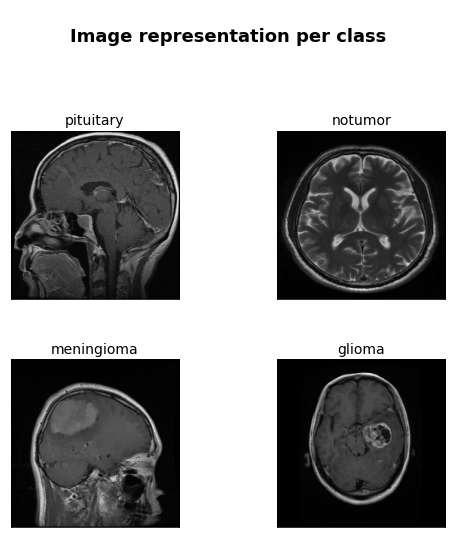

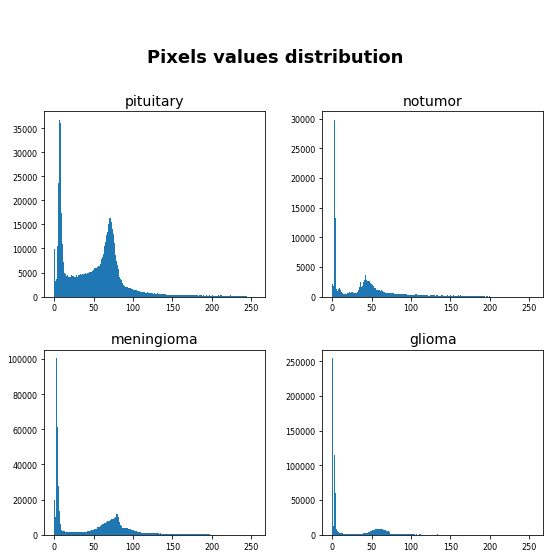

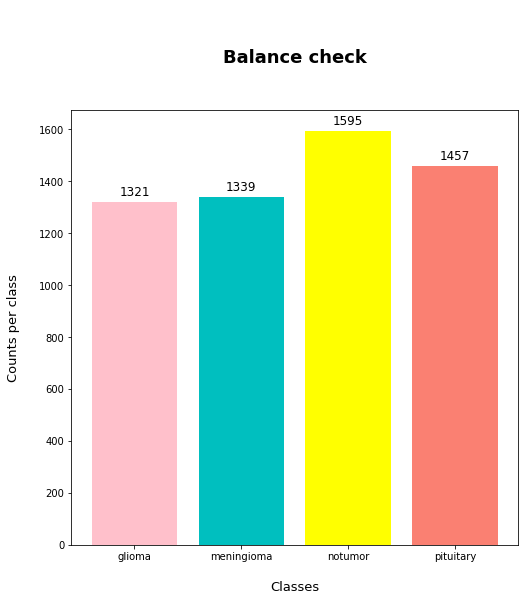

In [4]:
def data_exploration(dir_path, train_data):
    myimgs = []
    for folder, subfolders, files in os.walk(dir_path):
        for file in files:
            path, filename = os.path.split(folder)
            random_file = np.random.choice(files)
            file_path = os.path.join(path, filename, random_file)
            myimgs.append(file_path)
            break


    plt.figure(figsize=(8, 8))
    for i in range(len(myimgs)):
        plt.subplot(2, 2, i+1)
        imig = myimgs[i]
        title = imig.split('/')
        plt.title(title[5], fontsize=14)
        imig = plt.imread(imig)
        imig = cv2.resize(imig, (224, 224))
        plt.imshow(imig, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.suptitle('\nImage representation per class', fontsize=18, fontweight='bold')
    plt.tight_layout(pad=4)
    plt.show()
    

    plt.figure(figsize=(8, 8))
    for j in range(len(myimgs)):
        plt.subplot(2, 2, j + 1)
        img = myimgs[j]
        title = img.split('/')
        plt.title(title[5], fontsize=14)
        img = cv2.imread(img)
        plt.hist(img.ravel(), 256, [0, 255])
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout(pad=2)
        plt.suptitle('\n\nPixels values distribution', fontsize=18, fontweight='bold')
    plt.show()


    def add_values(classes,counts):
        for i in range(0, len(classes)):
            plt.text(i,counts[i]+25,counts[i], fontsize=12, horizontalalignment='center')
        
    my_classes = train_data.class_indices.keys()
    my_count = Counter(train_data.classes)    
    plt.figure(figsize=(8, 8))
    plt.bar(my_classes, my_count.values(), color=['pink', 'c', 'yellow', 'salmon'])
    add_values(my_classes,my_count)
    plt.ylabel('Counts per class\n', fontsize=13)
    plt.xlabel('\nClasses', fontsize=13)
    plt.title('\n\nBalance check\n\n', fontsize=18, fontweight='bold')
    plt.show()

data_exploration(train_dir, train_set)

<span style="font-size:18px;">In the first figure, you can see that the difference between some classes can be minor, and this can challenge the model to classify right.<span>
    
<span style="font-size:18px;">In the second figure, I wanted to see if there is a different pixel distribution between the classes and if there is a pixels range that characterized each class.<span>
    
<span style="font-size:18px;">In the third figure, you can see that the data is not balanced, so the next step is to balance the data.<span>

# **Balance the Data**

<span style="font-size:18px;">I decided to balance the data with a class weight approach that would give weight to each class in inverse proportion to the class size.<span>

In [5]:
from sklearn.utils import class_weight
classes = np.unique(train_set.classes)
weights_balance = class_weight.compute_class_weight(class_weight='balanced', classes=classes,y=train_set.classes)
class_weights = dict(zip(classes, weights_balance))
print(class_weights)

{0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


# **Callbacks**

In [6]:
def callbacks():
    checkpoint = ModelCheckpoint('best_vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

    return checkpoint, early

call_callbacks = callbacks()

# **Model Configuration and Fine-tuning**


<span style="font-size:18px;">To define the model, I built it like an experiment; to tune the hyperparameters, I tried to change one parameter at a time and examined how it affected the model in terms of loss and accuracy while avoiding overfitting.<span>
    
1. <span style="font-size:18px;"> **Training Depth** - I tried to train from Block 4 (layer 11) and Block 5 (layer 15). The best results were from layer 19 (combined with another hyperparameter tuning).<span>
    
2. <span style="font-size:18px;"> Regulatory factors - <span>
    
    *    <span style="font-size:18px;"> **L2** kernel regularization<span>
        
    *    <span style="font-size:18px;"> Adding **BatchNormalization** layer<span>
       
    *    <span style="font-size:18px;"> Adding **Dropout** layer(tuned the dropout rate between 0.3 to 0.5)<span>
        
3. <span style="font-size:18px;"> Different optimizer **learning rates** range<span>
    
4. <span style="font-size:18px;"> Number of **ephocs**<span>

In [7]:
def transfer_learning(layer_num=19):
    my_model = VGG16()
    for layers in (my_model.layers)[:layer_num]:
        layers.trainable = False

    flatten = my_model.layers[-4].output
    fc_1 = Dense(4096, activation='relu', kernel_regularizer='l2', name='FC_1')(flatten)
    bn_norm_1 = BatchNormalization(name='BN_1')(fc_1)
    drop_1 = Dropout(rate=0.5, name='Dropout_1')(bn_norm_1)
    fc_2 = Dense(4096, activation='relu', kernel_regularizer='l2', name='FC_2')(drop_1)
    bn_norm_2 = BatchNormalization(name='BN_2')(fc_2)
    drop_2 = Dropout(rate=0.5, name='Dropout_2')(bn_norm_2)
    predictions = Dense(4, activation='softmax', name='Predictions')(drop_2)
    final_model = Model(inputs=my_model.input, outputs=predictions)
    final_model.summary()

    return final_model

training_model = transfer_learning()

2022-04-07 20:25:25.382268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 20:25:25.473024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 20:25:25.473851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 20:25:25.475654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

# **Training the Model**

In [8]:
opt = Adam(learning_rate=0.00003)
training_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
hist = training_model.fit(train_set, validation_data=val_set, epochs=150, callbacks=call_callbacks, class_weight=class_weights, verbose=1)

2022-04-07 20:25:32.916125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-04-07 20:25:35.810339: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


179/179 [==============================] - 141s 730ms/step - loss: 94.7712 - accuracy: 0.7384 - val_loss: 81.0882 - val_accuracy: 0.7963

Epoch 00001: val_loss improved from inf to 81.08821, saving model to best_vgg16.h5
Epoch 2/150
179/179 [==============================] - 88s 490ms/step - loss: 72.9249 - accuracy: 0.8044 - val_loss: 66.0043 - val_accuracy: 0.8284

Epoch 00002: val_loss improved from 81.08821 to 66.00426, saving model to best_vgg16.h5
Epoch 3/150
179/179 [==============================] - 90s 499ms/step - loss: 61.2066 - accuracy: 0.8291 - val_loss: 57.0536 - val_accuracy: 0.8055

Epoch 00003: val_loss improved from 66.00426 to 57.05360, saving model to best_vgg16.h5
Epoch 4/150
179/179 [==============================] - 90s 499ms/step - loss: 53.6465 - accuracy: 0.8407 - val_loss: 50.6117 - val_accuracy: 0.8452

Epoch 00004: val_loss improved from 57.05360 to 50.61169, saving model to best_vgg16.h5
Epoch 5/150
179/179 [==============================] - 89s 495ms/ste

In [9]:
best_val_loss = min(hist.history['val_loss']) 
index_best_loss = hist.history['val_loss'].index(best_val_loss)
best_val_acc = hist.history['val_accuracy'][index_best_loss]
print(f'The best validation params - loss: {best_val_loss}, accuracy: {best_val_acc*100}%')

The best validation params - loss: 0.3877943456172943, accuracy: 96.41494750976562%


# **Loss and Accuracy Plots**

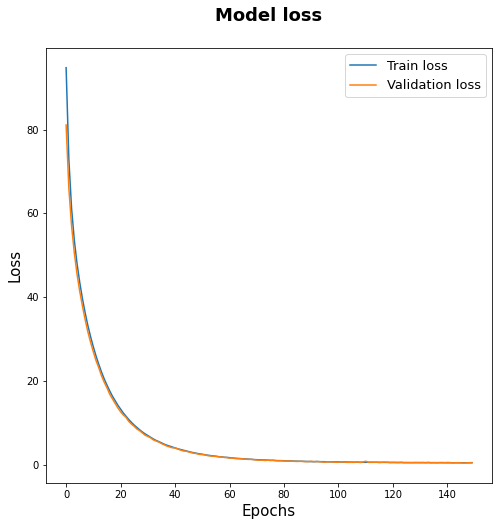

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss\n', fontsize=18, fontweight='bold')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train loss','Validation loss'], fontsize=13, loc='upper right')
plt.show()

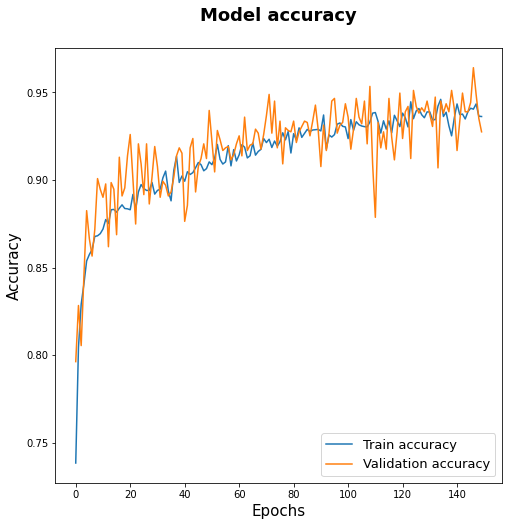

In [11]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy\n', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train accuracy','Validation accuracy'], fontsize=13, loc='lower right')
plt.show()

# **Prediction**

In [12]:
from sklearn.metrics import accuracy_score
test_set.reset()

filenames = test_set.filenames
nb_samples = np.ceil(test_set.n//test_set.batch_size)


make_predictions = training_model.predict(test_set,steps=nb_samples)
predicted_classes = np.argmax(make_predictions, axis=1)
labels = dict((v,k) for k,v in test_set.class_indices.items())
predictions = [labels[k] for k in predicted_classes]

test_score = accuracy_score(test_set.classes, predicted_classes) * 100
print('The accuracy score of the test data on the training model is: %0.2f%% ' % (test_score))

The accuracy score of the test data on the training model is: 94.96% 


# **Evaluate Model Performance**

Classification report: 
 
               precision    recall  f1-score   support

      glioma       0.90      0.98      0.94       175
  meningioma       0.97      0.83      0.89       139
     notumor       0.99      0.99      0.99       162
   pituitary       0.96      0.98      0.97       179

    accuracy                           0.95       655
   macro avg       0.95      0.94      0.95       655
weighted avg       0.95      0.95      0.95       655



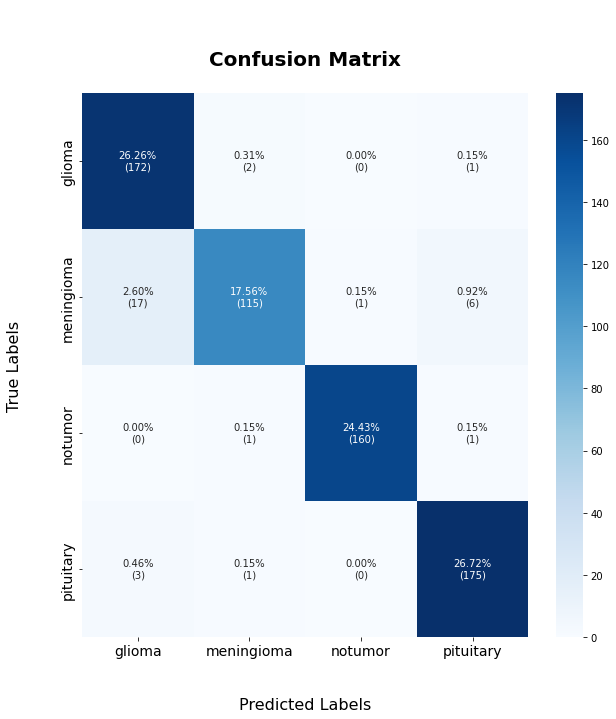

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_test = test_set.classes

target_names =[]
for k,v in test_set.class_indices.items():
  target_names.append(f'{k}')

test_report = classification_report(y_test, predicted_classes, target_names=target_names)
print(f'Classification report: \n \n {test_report}')

conf_mat = confusion_matrix(y_test, predicted_classes)

def confusion_matrix_visualization(cm, tick_labels, file_name):
    
    plt.figure(figsize=(10, 10))
    
    class_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    class_counts = ['{:.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n({v2})' for v1, v2,  in zip(class_percentages, class_counts)]
    labels = np.asarray(labels).reshape(4,4)
    
    ax = sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    ax.set_title('\n\nConfusion Matrix\n', fontsize=20, fontweight='bold');
    ax.set_xlabel('\n\nPredicted Labels', fontsize=16)
    ax.set_ylabel('True Labels\n\n ', fontsize=16);
    ax.xaxis.set_ticklabels(tick_labels, fontsize=14)
    ax.yaxis.set_ticklabels(tick_labels, fontsize=14)
    
    plt.savefig(file_name)
    plt.show()


confusion_matrix_visualization(conf_mat, target_names, file_name='confusion_matrix.png')

# **Conclusions**

<span style="font-size:18px;">In this project, I performed transfer learning with VGG-16 architecture to classify MRI Brain Tumors.<span>
    
<span style="font-size:18px;">There were a few challenges to the model -  the images in grayscale, and small differences between some classes that can be difficult for the model to classify right.<span>
    
<span style="font-size:18px;">Despite the challenging data, the model performance was very good, by looking at the test accuracy score, and the confusion matrix, I think the model did a good job :-)<span>
    
<span style="font-size:18px;">I learned a lot from this project, it's enriched my knowledge, and I enjoyed researching things in depth.<span>
    
<span style="font-size:18px;">I would be happy to get comments and insights😁<span>